In [1]:
#builtin
import json
import os
from datetime import datetime

#external
import gdal
import numpy as np
import pyproj
import rasterio as rio
import requests
from rasterio.enums import ColorInterp
from rasterio.mask import mask
from rasterio.warp import Resampling
from shapely.geometry import Polygon
from shapely.ops import transform

In [2]:
EARTHDATA_CMR_STAC = 'https://cmr.earthdata.nasa.gov/stac/'

In [3]:
stac_response = requests.get(EARTHDATA_CMR_STAC).json()
# Search for only LP-specific catalogs
stac_lp = [s for s in stac_response['links'] if 'LP' in s['title']]
lp_cloud = requests.get([s for s in stac_lp if s['title'] == 'LPCLOUD'][0]['href']).json()
print(json.dumps(lp_cloud, indent=2))

{
  "id": "LPCLOUD",
  "title": "LPCLOUD",
  "description": "Root catalog for LPCLOUD",
  "stac_version": "1.0.0-beta.1",
  "links": [
    {
      "rel": "self",
      "href": "https://cmr.earthdata.nasa.gov/stac/LPCLOUD",
      "title": "Provider catalog",
      "type": "application/json"
    },
    {
      "rel": "root",
      "href": "https://cmr.earthdata.nasa.gov/stac/",
      "title": "CMR-STAC Root catalog",
      "type": "application/json"
    },
    {
      "rel": "collections",
      "href": "https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections",
      "title": "Provider Collections",
      "type": "application/json"
    },
    {
      "rel": "search",
      "href": "https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search",
      "title": "Provider Item Search",
      "type": "application/json"
    },
    {
      "rel": "child",
      "href": "https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/C1711924822-LPCLOUD",
      "title": "HLS Sentinel-2 Multi-spectral Instrument S

In [4]:
hls_collection = [l['href'] for l in lp_cloud['links'] if 'HLS' in l['title']][0]
hls_response = requests.get(hls_collection).json()
hls_search_url = [l['href'] for l in hls_response['links'] if l['rel'] == 'stac'][0]
print(json.dumps(hls_response, indent=2))

{
  "id": "C1711924822-LPCLOUD",
  "short_name": "HLSS30",
  "stac_version": "1.0.0-beta.1",
  "license": "not-provided",
  "title": "HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30 m V1.5",
  "description": "PROVISIONAL - The Harmonized Landsat and Sentinel-2 (HLS)  data have not been validated for their science quality and should not be used in science research or applications. The HLS project provides consistent surface reflectance data from the Operational Land Imager (OLI) aboard the joint NASA/USGS Landsat 8 satellite and the Multi-Spectral Instrument (MSI) aboard the European Union\u2019s Copernicus Sentinel-2A and Sentinel-2B satellites. The combined measurement enables global observations of the land every 2-3 days at 30 meter (m) spatial resolution. The HLS project uses a set of algorithms to obtain seamless products from OLI and MSI that include atmospheric correction, cloud and cloud-shadow masking, spatial co-registration and common gridding, i

{
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -87.8741455078125,
          80.3025547350612
        ],
        [
          -87.5006103515625,
          80.02955732601929
        ],
        [
          -86.51184082031249,
          79.72938465835632
        ],
        [
          -85.10009765625,
          79.88201996361602
        ],
        [
          -85.484619140625,
          80.30718013404172
        ],
        [
          -87.8741455078125,
          80.3025547350612
        ]
      ]
    ]
  }
}


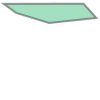

In [5]:
# load a search polygon (Eureka)
with open('../assets/query_aoi.geojson') as f:
    aoi = json.load(f)['features'][0]
print(json.dumps(aoi, indent=2))
poly = Polygon(aoi['geometry']['coordinates'][0])
poly

In [6]:
# unclear how the STAC `intersects` parameter works - might be misconfigured NASA-side as it produces wrong results when used with raw geojson
search_params = {
    'limit': 10,
    'bounding_box': f'{",".join([str(round(f,3)) for f in list(poly.bounds)])}', # this param should be `bbox` according to STAC-spec
    'datetime': '2020-07-09T20:50:00Z/2020-07-09T20:55:00Z',
    #'intersects': aoi
}
print(json.dumps(search_params, indent=2))

{
  "limit": 10,
  "bounding_box": "-87.874,79.729,-85.1,80.307",
  "datetime": "2020-07-09T20:50:00Z/2020-07-09T20:55:00Z"
}


In [7]:
search_str = '&' + '&'.join(['{}={}'.format(k,v) for (k,v) in search_params.items()])
search_query = hls_search_url + search_str
search_query

'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search?collections=C1711924822-LPCLOUD&limit=10&bounding_box=-87.874,79.729,-85.1,80.307&datetime=2020-07-09T20:50:00Z/2020-07-09T20:55:00Z'

In [8]:
search_response = requests.get(search_query).json()
print('%d features found with first query' % len(search_response['features']))
feats = search_response['features']
# pagination is cool
try:
    next_page = [l['href'] for l in search_response['links'] if l['rel'] == 'next'][0]
except IndexError:
    next_page = None
while next_page is not None:
    search_response = requests.get(next_page).json()
    feats.extend(search_response['features'])
    try:
        next_page = [l['href'] for l in search_response['links'] if l['rel'] == 'next'][0]
    except IndexError:
        next_page = None
print('%d total features found by the query parameters' % len(feats))

8 features found with first query
8 total features found by the query parameters


In [9]:
[f['properties']['datetime'] for f in feats]

['2020-07-09T20:51:16.829Z',
 '2020-07-09T20:51:18.232Z',
 '2020-07-09T20:51:20.001Z',
 '2020-07-09T20:51:22.809Z',
 '2020-07-09T20:51:32.242Z',
 '2020-07-09T20:51:33.599Z',
 '2020-07-09T20:51:37.402Z',
 '2020-07-09T20:51:40.193Z']

In [10]:
search_response['features'][0]

{'type': 'Feature',
 'id': 'G1947816187-LPCLOUD',
 'stac_version': '1.0.0-beta.1',
 'stac_extensions': ['eo'],
 'collection': 'C1711924822-LPCLOUD',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.186221, 80.0371955],
    [-80.4926746, 80.0767959],
    [-80.4373911, 81.0604569],
    [-83.5624131, 81.0520772],
    [-86.7477998, 81.0164388],
    [-86.186221, 80.0371955]]]},
 'bbox': [-86.7478, 80.037196, -80.437391, 81.060881],
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/C1711924822-LPCLOUD/items/G1947816187-LPCLOUD'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/C1711924822-LPCLOUD'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/C1711924822-LPCLOUD'},
  {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/'},
  {'rel': 'provider', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'}],
 'properties': {'datetime': '2020-07-09T20:51

In [11]:
def remote_to_local(stac_feature, target_dir):
    '''
    Given an Earthdata STAC feature (dictionary), construct a local geotif using
    the RGB channels from the remote STAC feature
    '''
    # extract some information
    tile_str, date_str = stac_feature["assets"]["Fmask"]["href"].split(".")[-6:-4]
    tif_date = datetime.strptime(date_str, '%Y%jT%H%M%S')
    # product.type.datetime.tileindex.version.tif
    tif_name = os.path.join(
        target_dir, 
        f'HLS.S30.{tif_date.strftime("%Y%m%dT%H%M%S")}.{tile_str}.v1.5.tif'
    )
    if os.path.exists(tif_name):
        return tif_name
    # get RGB sources
    r = rio.open(stac_feature['assets']['B04']['href'])
    # save a copy of the red-band metadata for later use
    meta = r.meta.copy()
    g = rio.open(stac_feature['assets']['B03']['href'])
    b = rio.open(stac_feature['assets']['B02']['href'])
    # transform clip-geometry to match source
    src = pyproj.CRS.from_epsg(4326)
    dst = pyproj.CRS(r.crs)
    trans = pyproj.Transformer.from_crs(crs_from=src, crs_to=dst, always_xy=True)
    poly_utm = transform(trans.transform, poly)
    # apply clip-geometry to source
    r_masked, mask_transform = mask(r, [poly_utm], crop=True)
    g_masked, _ = mask(g, [poly_utm], crop=True)
    b_masked, _ = mask(b, [poly_utm], crop=True)
    # update the metadata to match the new clipped boundaries and add some tiling/compression stuff
    meta.update({
        'count': 3,
        'height': r_masked.shape[1],
        'width': r_masked.shape[2],
        'transform': mask_transform,
        'tiled': True,    
        'compress': 'DEFLATE',
        'tilexsize': 256,
        'tileysize': 256,
    })
    # create the local dataset and build overviews for a series of zoomlevels
    with rio.open(tif_name, 'w', **meta) as dst:
        for band_id, band in enumerate([r_masked, g_masked, b_masked], start=1):
            dst.write_band(band_id, band[0])
        dst.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue]
        dst.build_overviews([2, 4, 8, 16], Resampling.cubic)
        dst.update_tags(ns='rio_overview', resampling=Resampling.cubic)
    return tif_name

In [12]:
%%time
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl
with rio.Env(
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS='.tif',
    GDAL_DISABLE_READDIR_ON_OPEN='YES',
    GDAL_HTTP_UNSAFESSL='YES',
    GDAL_HTTP_COOKIEFILE='~/cookies.txt',
    GDAL_HTTP_COOKIEJAR='~/cookies.txt'
):
    tifs = [
        remote_to_local(feat, '../scratch/')
        for feat in feats
    ]
tifs

CPU times: user 4.36 s, sys: 172 ms, total: 4.53 s
Wall time: 3min 31s


['../scratch/HLS.S30.20200709T205031.T17XMK.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T16XEQ.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T17XMJ.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T16XEP.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T16XDQ.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T15XWK.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T16XDP.v1.5.tif',
 '../scratch/HLS.S30.20200709T205031.T15XWJ.v1.5.tif']